# Generalized Galton Board Simulator

<img  src="figures/plinko_histogram.png"  width="340" align="right" />


This notebook demos the simulation for a generalization of the [Galton board](https://en.wikipedia.org/wiki/Bean_machine) (or "bean machine"), in which a set of balls is dropped through a lattice of nails ending in one of several bins denoted by `x`. The Galton board is commonly used to demonstrate the central limit theorem, and if the nails are uniformly placed such that the probability of bouncing to the left is `p`, the sum over the latent space is tractable analytically and the resulting distribution of `x` is a binomial distribution with `N_rows` trials and probability `p` of success. However, if the nails are not uniformly placed, and the probability of bouncing to the left is an arbitrary function of the nail position and some parameter `θ`, the resulting distribution requires an explicit sum over the latent paths `z` that might lead to a particular `x`. Such a distribution would become intractable as `N_rows`, the size of the lattice of nails, increases. 

In this toy example, the probability `p(zh, zv, θ)` of going left is given by `(1−f(zv))/2+f(zv)σ(5θ(zh −1/2))`, where `f(zv) = sin(π zv)`, `σ` is the sigmoid function, and `zh` and `zv` are the horizontal and vertical nail positions normalized to `[0, 1]`. This leads to a non-trivial `p(x|θ)`, which can even be bimodal. The figure shows an example of two latent trajectories that lead to the same `x`.

In [1]:
import sys
import collections
import numpy as np
from scipy.stats import norm

%matplotlib notebook
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection
from matplotlib import gridspec

import import_ipynb

# Settings

In [21]:
# Parameter values used to generate data
thetas = np.linspace(-1.,0.,6)
n_thetas = len(thetas)

# Two benchmark parameter values
theta0 = 1
theta1 = 2
print(thetas[theta0], thetas[theta1])

# Observable range
n_positions = 32
xmin = 0
xmax = n_positions - 1
x_values = np.linspace(xmin, xmax, n_positions)

# Which z trajectory to plot
example_theta = theta0
example_trajectories = [15, 37]

# How many samples for example histogram
n_samples_histo = 100

-0.8 -0.6


# Generate data

This takes some time, you can skip this since the data is saved in the `.npy` files.

In [22]:
%%script false # this will skip the execution of this cell, comment it out if you want to re-run it.
from galton import nail_positions
from galton import galton_rvs

n_samples = 100
thetas_ = thetas

x, t_xz, trajectories, positions = [], [], [], []

for i, theta_ in enumerate(thetas_):
    print("theta =", theta_)

    positions.append(nail_positions(theta_))
    x_, _, t_xz_, trajectories_ = galton_rvs(
        theta_, n_runs=n_samples, random_state=1234 + i
    )

    x.append(x_)
    t_xz.append(t_xz_)
    trajectories.append(trajectories_[:100])
    #positions.append(nail_positions_)

np.save("data/x.npy", x)
np.save("data/t_xz.npy", t_xz)
np.save("data/trajectories.npy", trajectories)
np.save("data/nail_positions.npy", positions)

In [76]:
#%%script false # this will skip the execution of this cell, comment it out if you want to re-run it.
from galton import nail_positions
from galton import galton_rvs_ratio

n_samples = 10000
thetas_ = thetas

x, t_xz, logr_xz, trajectories, positions = [], [], [], [], []

for i, theta_ in enumerate(thetas):
    print("theta =", theta_)

    nail_positions_ = nail_positions(theta_)
    x_, log_p_xz_0_, log_p_xz_1_, t_xz_, _, trajectories_ = galton_rvs_ratio(
        theta_, thetas[theta1], n_runs=n_samples, random_state=1234 + i
    )

    x.append(x_)
    t_xz.append(t_xz_)
    logr_xz.append(log_p_xz_0_-log_p_xz_1_)
    trajectories.append(trajectories_[:100])
    positions.append(nail_positions_)

np.save("data/x.npy", x)
np.save("data/t_xz.npy", t_xz)
np.save("data/logr_xz.npy", logr_xz)
np.save("data/trajectories.npy", trajectories)
np.save("data/nail_positions.npy", positions)

theta = -1.0
theta = -0.8
theta = -0.6
theta = -0.4
theta = -0.2
theta = 0.0


# Load data

In [77]:
# Shape (n_thetas, n_samples)

# standard data from simulator
x = np.load("data/x.npy")

# Augmented data from mining 
logr_xz = np.load('data/logr_xz.npy')
t_xz = np.load("data/t_xz.npy")

# Nail positions / thresholds. Shape (n_thetas, n_rows, n_nails)
nail_positions = np.load("data/nail_positions.npy")
n_rows, n_nails = nail_positions[theta0].shape
assert n_nails == n_positions - 1

# Example trajectories. Shape (n_thetas, n_rows + 2), consisting of (begin, z, x)
trajectories = np.load("data/trajectories.npy")

## Latent trajectories associated to different values of x 

In [78]:
for x_final in range(n_positions):
    candidates = []
    for i, tr_ in enumerate(trajectories[theta0]):
        if tr_[-1] == x_final:
            candidates.append(i)
    if len(candidates) > 0:
        print(x_final, candidates)

6 [60, 73, 75]
7 [46, 74, 79]
8 [10, 63, 94]
9 [7, 22, 43, 59, 67, 81, 84]
10 [76, 96]
11 [3, 15, 34, 37]
12 [9, 12, 25, 48, 50, 54, 70, 72, 77, 82, 97]
13 [51, 78]
14 [30, 33, 65, 95]
15 [5, 17, 29, 40, 57, 58, 62, 87, 93]
16 [6, 8, 35, 36, 39, 44, 52, 61, 83, 85, 88]
17 [26, 41, 56, 66, 68, 90]
18 [13, 14, 16, 24, 80, 89]
19 [1, 18, 19, 23, 28, 32, 38, 49, 55, 86, 92, 99]
20 [2, 4, 11, 64, 71, 91]
21 [27]
22 [20, 21, 31, 42, 45, 69, 98]
23 [53]
24 [0, 47]


# "True densities" and ratios from histogram

The probability density (really it's a probability mass function since x is discrete) implicitly defined by this simulator is intractable. To estimate the true density we run the simulator many times and make histograms for the outcomes. These are estimates of the implicit distributions, but inefficient for inference. 

In [79]:
p_x, p_hat_x = [], []

for x_ in x:
    histo, _ = np.histogram(
        x_, bins=n_positions, range=(xmin - 0.5, xmax + 0.5), density=True
    )
    p_x.append(histo)
    histo, _ = np.histogram(
        x_[:n_samples_histo],
        bins=n_positions,
        range=(xmin - 0.5, xmax + 0.5),
        density=True,
    )
    p_hat_x.append(histo)

p_x = np.asarray(p_x)
p_hat_x = np.asarray(p_hat_x)

r_x = p_x / p_x[theta1]
logr_x = np.log(r_x)
s_x = 1. / (1. + r_x)

/Users/cranmer/anaconda/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/cranmer/anaconda/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


# Plotting settings

In [80]:
colors = ["#CC002E","orange","mediumblue","darkgreen","c","#be96ff","0.65","black",]

In [81]:
our_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name="rascascal", colors=["#CC002E", "0.85", "mediumblue"], N=201
)
our_cmap_r = mpl.colors.LinearSegmentedColormap.from_list(
    name="rascascal_r", colors=["mediumblue", "0.85", "#CC002E"], N=201
)


def cmap_color(x, xmin=0., xmax=1.):
    # cmap = mpl.cm.RdYlBu
    return our_cmap((x - xmin) / (xmax - xmin))


def viridis_color(x, xmin=0., xmax=1.):
    cmap = mpl.cm.viridis
    return cmap((x - xmin) / (xmax - xmin))

In [82]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_sep_absolute = 8. * 0.02
margin_sep_small_absolute = 8. * 0.005
margin_t_absolute = 8. * 0.02
margin_t_absolute_extra = 8. * 0.12
margin_b_absolute = 8. * 0.08


def custom_figure(
    n_panels=2,
    width=8.,
    panel_aspect_ratio=1.,
    extra_top_space=False,
    reduce_vertical_sep=False,
):

    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1

    # Determine top margin
    _margin_t_absolute = (
        margin_t_absolute_extra if extra_top_space else margin_t_absolute
    )

    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (
        1. - margin_l - margin_r - (n_panels_h - 1) * margin_sep_total
    ) / n_panels_h

    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width

    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = (
        n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute)
        + (n_panels_v - 1) * margin_sep_absolute
    )

    # Calculate vertical margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    if reduce_vertical_sep:
        margin_sep_total = margin_sep_small_absolute / height
    else:
        margin_sep_total = margin_t + margin_b + margin_sep_absolute / height

    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height

    # New figure
    fig = plt.figure(figsize=(width, height))

    # Adjust margins
    plt.subplots_adjust(
        left=margin_l,
        right=1. - margin_r,
        bottom=margin_b,
        top=1. - margin_t,
        wspace=wspace,
        hspace=hspace,
    )

    return fig

# Plot Plinko board, example trajectory, and histograms

<IPython.core.display.Javascript object>


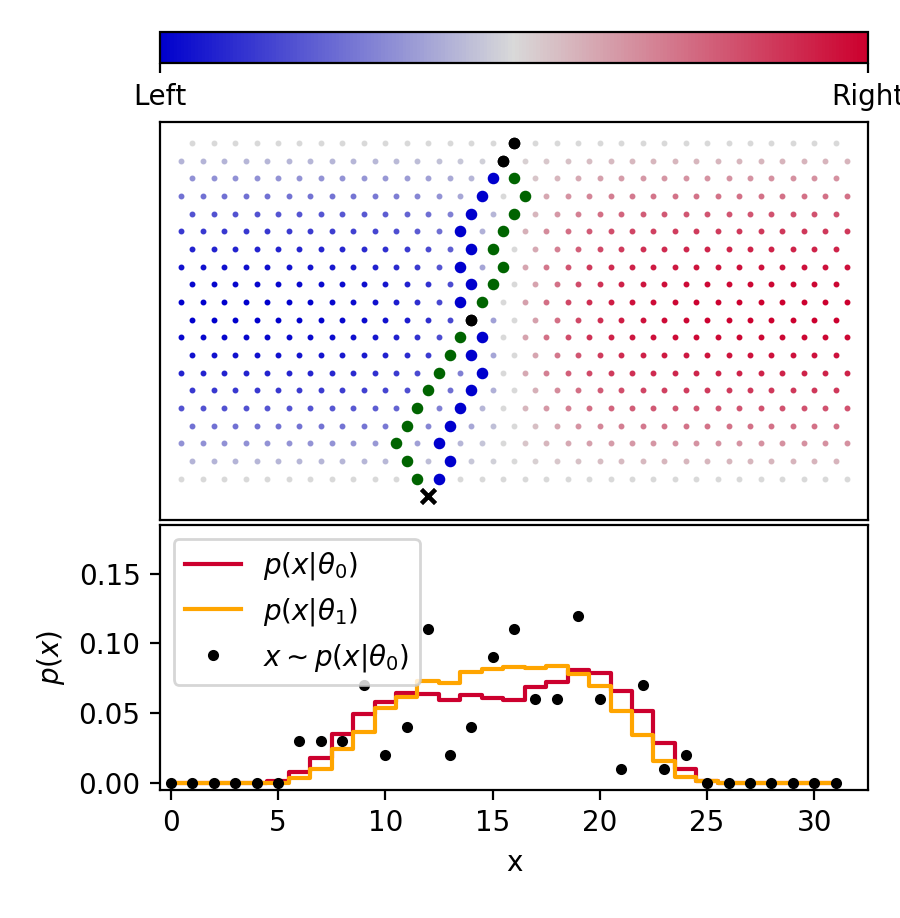

/Users/cranmer/anaconda/envs/simulator-mining-example/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


In [83]:
fig = custom_figure((1, 2), 4.5, 2.5, reduce_vertical_sep=True)
gs = gridspec.GridSpec(4, 1, height_ratios=[0.12, 0.18, 1.5, 1])
#gs = gridspec.GridSpec(3, 1, height_ratios=[0.12, 1.5, 1])
# gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 1])


ax0 = plt.subplot(gs[3])
# ax0 = plt.subplot(gs[2])

for i, t in enumerate([theta0, theta1]):
    plt.step(
        x_values,
        p_x[t],
        where="mid",
        c=colors[i],
        lw=1.5,
        ls="-",
        label=r"$p(x|\theta_" + str(i) + "$)",
    )

plt.plot(
    x_values,
    p_hat_x[theta0],
    color="black",
    ls=" ",
    marker="o",
    ms=3.,
    label=r"$x \sim p(x | \theta_0)$",
)

plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel("$p(x)$")
plt.xlim(xmin - 0.5, xmax + 0.5)
plt.ylim(-0.005, 0.185)


ax = plt.subplot(gs[2], sharex=ax0)
# ax = plt.subplot(gs[1], sharex=ax0)

for r in range(n_rows):
    offset = 0.5 if r % 2 == 0 else 0

    for i in range(n_nails + (0 if r % 2 == 0 else 1)):
        nail_position = nail_positions[example_theta][r, min(i, n_nails - 1)]
        plt.scatter(
            [offset + i + 0.5],
            [-r],
            color=cmap_color(nail_position),
            s=5.,
            marker=".",
            alpha=1.,
        )

for i, ex in enumerate(example_trajectories):
    trajectory = trajectories[example_theta, ex]
    pos = trajectory[0]
    z = trajectory[1:-1]
    x_ = trajectory[-1]

    for r in range(n_rows):
        offset = 0.5 if r % 2 == 0 else 0
        plt.scatter(
            [offset + pos + 0.5],
            [-r],
            color="black" if r in [0, 1, 10] else colors[2 + i],
            s=10.,
            marker="o",
            alpha=1.,
        )

        if z[r] == 0:
            if r % 2 == 0:
                pos = pos
            else:
                pos = pos - 1
        else:
            if r % 2 == 0:
                pos = pos + 1
            else:
                pos = pos

    offset = 0.5 if (r + 1) % 2 == 0 else 0
    plt.scatter([offset + x_ + 0.5], [-r - 1], marker="x", color=colors[-1], s=25.)

plt.xlim(xmin - 0.5, xmax + 1.5)
ax.xaxis.set_ticks_position("none")
ax.yaxis.set_ticks_position("none")
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)


ax = plt.subplot(gs[0])

norm = mpl.colors.Normalize(vmin=0., vmax=1.)
cb1 = mpl.colorbar.ColorbarBase(
    ax, cmap=our_cmap_r, norm=norm, orientation="horizontal"
)
#cb1.set_ticks([])
cb1.set_ticks([0.,1.])
cb1.set_ticklabels(['Left', 'Right'])


plt.savefig("figures/plinko_histogram.pdf")
plt.savefig("figures/plinko_histogram.png")

# Visualizing data used for likelihood ratio trick / CARL

In the likelihood ratio trick, the likelihood ratio $r(x| \theta_0, \theta_1) = p(x|\theta_0)/p(x|\theta_1)$ are estimated by training a discriminative classifier, where training data $x \sim p(x|\theta_0)$ are given the label $y=0$ and training data $x ~\sim p(x|\theta_1)$ are given the label $y=1$. The classifier then approximates
\begin{equation}
s^*(x| \theta_0, \theta_1) = \frac{p(x|\theta_1)}{p(x|\theta_0)+p(x|\theta_1)}
\end{equation}
which is 1-to-1 with $r(x|\theta_0, \theta_1)$. 

The Figure below shows that the classifier is learning $s^*(x| \theta_0, \theta_1)$ simply by the excess or deficit of samples $x$ for $y=0$ or $y=1$.

<IPython.core.display.Javascript object>


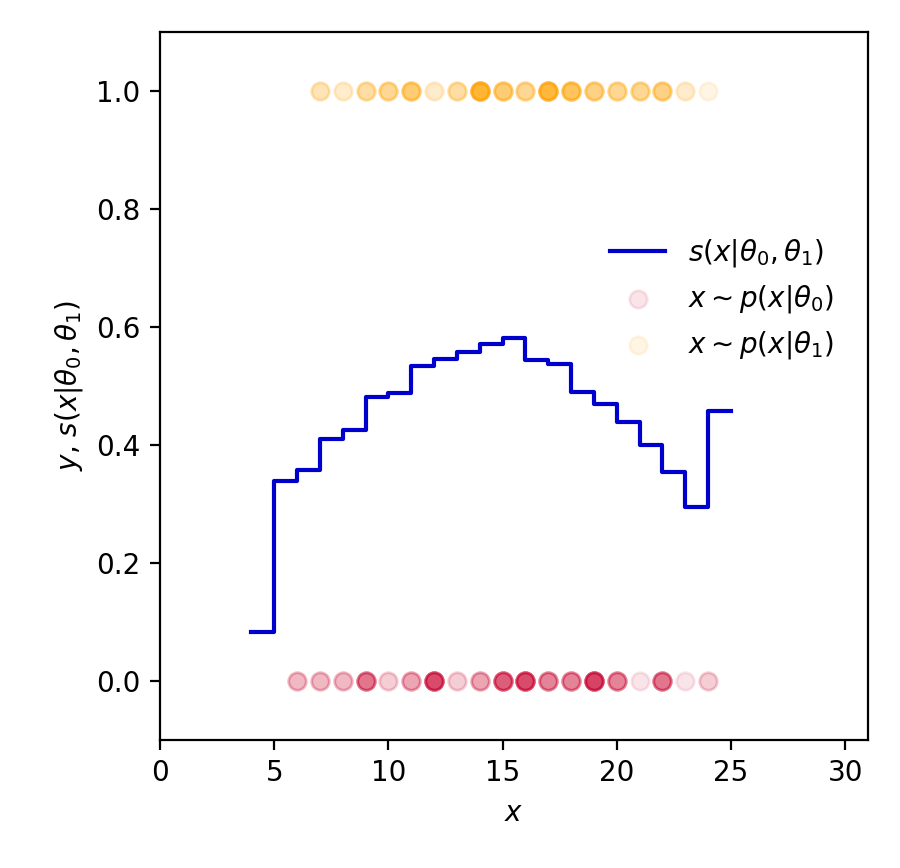

In [84]:
fig = custom_figure(1, 4.5, 1.)
ax = plt.gca()

plt.scatter(
    x[theta0][:n_samples_histo],
    np.zeros_like(x[theta0][:n_samples_histo]),
    s=40.,
    c=colors[0],
    alpha=.1,
    label=r"$x \sim p(x | \theta_0)$",
)
plt.scatter(
    x[theta1][:n_samples_histo],
    np.ones_like(x[theta1][:n_samples_histo]),
    s=40.,
    c=colors[1],
    alpha=.1,
    label=r"$x \sim p(x | \theta_1)$",
)
plt.step(x_values, s_x[theta0], color=colors[2], lw=1.5, label=r"$s(x|\theta_0, \theta_1)$")

plt.legend(loc='lower left',frameon=False, bbox_to_anchor=(0.6, 0.5))

plt.xlabel("$x$")
plt.ylabel(r"$y$, $s(x| \theta_0, \theta_1)$")

plt.xlim(xmin, xmax)
plt.ylim(-0.1, 1.1)
ax.set_yticks([0., 0.2, 0.4, 0.6, 0.8, 1.])

plt.savefig("figures/plinko_carl.pdf")
plt.savefig("figures/plinko_carl.png")

<IPython.core.display.Javascript object>


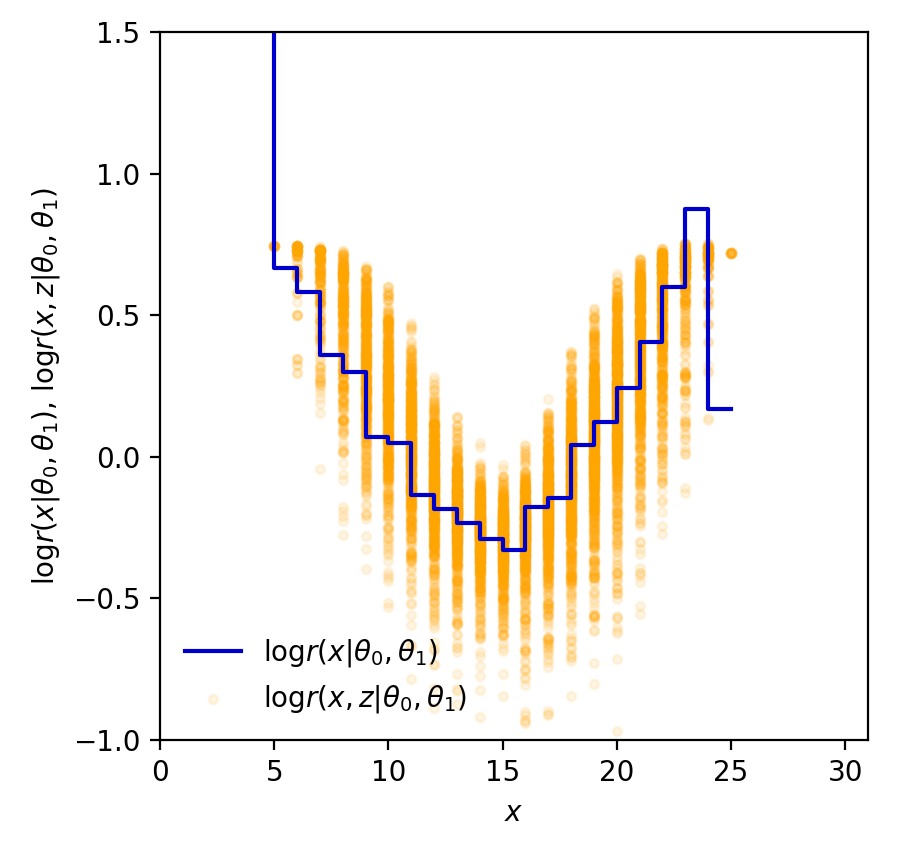

In [85]:
fig = custom_figure(1, 4.5, 1.)
ax = plt.gca()

plt.step(x_values, logr_x[theta0], color=colors[2], lw=1.5, label=r"$\log r(x|\theta_0, \theta_1)$")

plt.scatter(
    x[theta0],logr_xz[theta0],
    s=10.,
    c=colors[1],
    alpha=.1,
    label=r"$\log r(x,z | \theta_0, \theta_1)$",
)


plt.legend(loc='lower left',frameon=False)

plt.xlabel("$x$")
plt.ylabel(r"$\log r(x| \theta_0, \theta_1)$, $\log r(x,z| \theta_0, \theta_1)$")

plt.xlim(xmin, xmax)
plt.ylim(-1., 1.5)
#ax.set_yticks([0., 0.2, 0.4, 0.6, 0.8, 1.])

plt.savefig("figures/plinko_rolr.pdf")
plt.savefig("figures/plinko_rolr.png")

In [86]:
logr_x.shape
thetas.shape
x_values.shape
thetas

array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ])

<IPython.core.display.Javascript object>


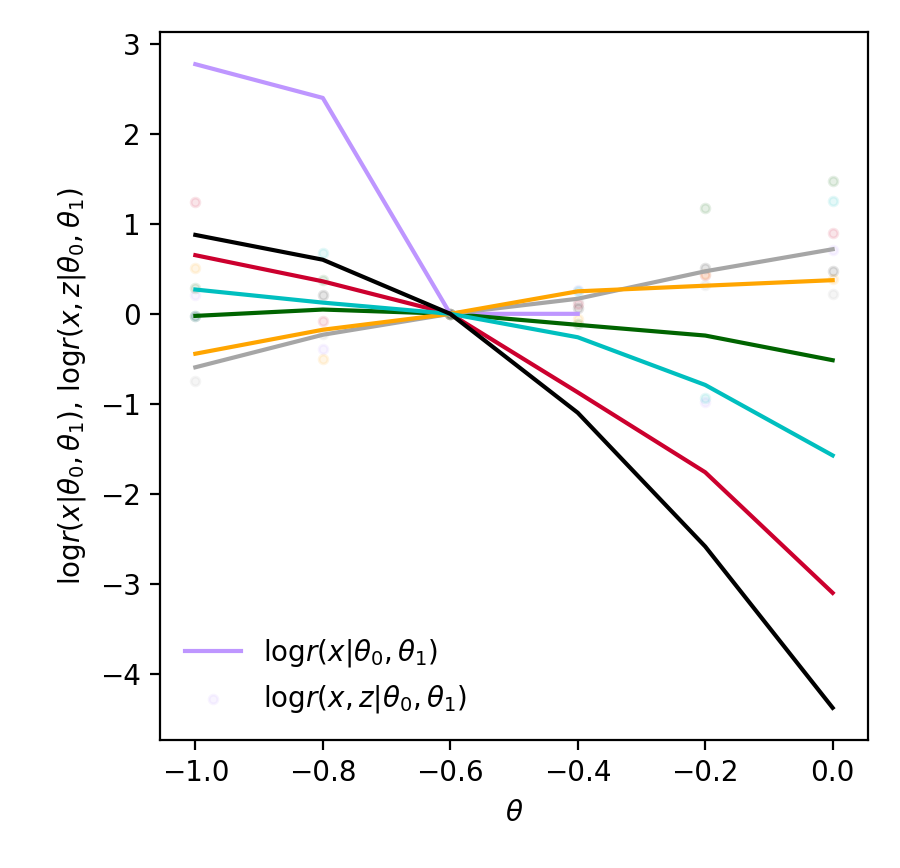

In [87]:
fig = custom_figure(1, 4.5, 1.)
ax = plt.gca()

add_legend=True
for x_ in range(5,25,3):
    c_ = colors[x_%len(colors)]
    if add_legend:
        plt.plot(thetas, logr_x[:,x_], lw=1.5, c=c_, label=r"$\log r(x|\theta_0, \theta_1)$")
        
        plt.scatter(
            thetas,logr_xz[:,x_],
            s=10.,
            c=c_,
            alpha=.1,
            label=r"$\log r(x,z | \theta_0, \theta_1)$",
        )
        add_legend=False

    else:
        plt.plot(thetas, logr_x[:,x_], c=c_, lw=1.5)

        plt.scatter(
            thetas,logr_xz[:,x_],
            s=10.,
            c=c_,
            alpha=.1,
        )


plt.legend(loc='lower left',frameon=False)

plt.xlabel(r"$\theta$")
plt.ylabel(r"$\log r(x| \theta_0, \theta_1)$, $\log r(x,z| \theta_0, \theta_1)$")

#plt.xlim(xmin, xmax)
#plt.ylim(-1., 1.5)
#ax.set_yticks([0., 0.2, 0.4, 0.6, 0.8, 1.])

plt.savefig("figures/plinko_rascal.pdf")
plt.savefig("figures/plinko_rascal.png")

# 3D plot

<IPython.core.display.Javascript object>


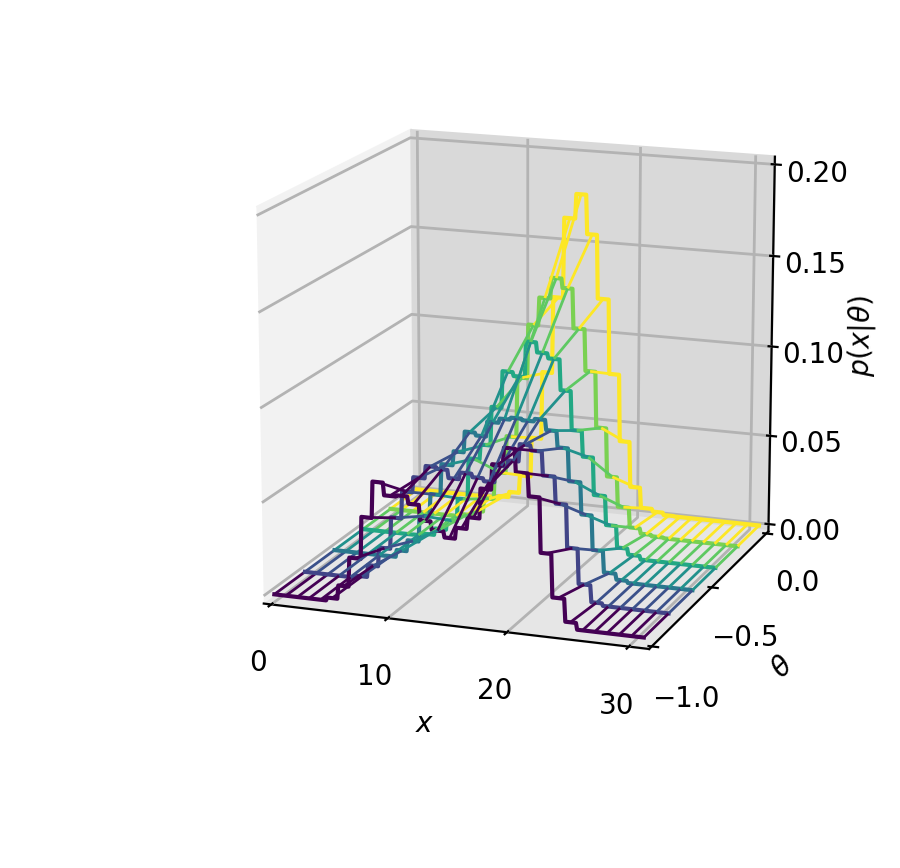

In [88]:
fig = custom_figure(1, 4.5, 1.)
ax = plt.subplot(1, 1, 1, projection="3d")

ax.view_init(elev=15., azim=-70)

# Lines with constant theta
for t, theta in reversed(list(enumerate(thetas))):
    x_ = np.linspace(xmin, xmax, n_positions * 10)
    p_ = np.asarray([p_x[t][int(round(xi, 0))] for xi in x_])
    theta_ = theta * np.ones_like(x_)

    ax.plot(x_, theta_, p_, c=viridis_color(theta, -1., 0.), lw=1.5, alpha=1.)

# Lines of constant x
for x_ in range(n_positions):
    segments = []
    for t in range(n_thetas - 1):
        theta_begin = thetas[t]
        theta_end = thetas[t + 1]
        p_begin = p_x[t][x_]
        p_end = p_x[t + 1][x_]
        segments.append([(x_, theta_begin, p_begin), (x_, theta_end, p_end)])
    segments = np.asarray(segments)

    lc = Line3DCollection(segments, cmap="viridis")
    lc.set_array(thetas[:-1])
    lc.set_linewidth(1.)
    lc.set_alpha(1.)

    ax.add_collection(lc)

ax.set_xlabel("$x$")
ax.set_zlabel(r"$p(x| \theta)$")
ax.set_ylabel(r"$\theta$")
ax.set_xlim(0., 31.)
ax.set_zlim(0., 0.2)
ax.set_ylim(-1., 0.)
ax.set_xticks(np.linspace(0., 30., 4))
ax.set_yticks([-1., -0.5, 0.])
ax.set_zticks([0., 0.05, 0.1, 0.15, 0.2])

ax.dist = 10.

ax.w_xaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
ax.w_yaxis.set_pane_color((0.85, 0.85, 0.85, 1.0))
ax.w_zaxis.set_pane_color((0.9, 0.9, 0.9, 1.0))
ax.w_xaxis._axinfo.update(
    {"grid": {"color": (0.7, 0.7, 0.7, 1.), "linewidth": 1., "linestyle": "-"}}
)
ax.w_yaxis._axinfo.update(
    {"grid": {"color": (0.7, 0.7, 0.7, 0.), "linewidth": 1., "linestyle": "-"}}
)
ax.w_zaxis._axinfo.update(
    {"grid": {"color": (0.7, 0.7, 0.7, 1.), "linewidth": 1., "linestyle": "-"}}
)

plt.savefig("figures/plinko_3d.pdf")
plt.savefig("figures/plinko_3d.png")

<IPython.core.display.Javascript object>


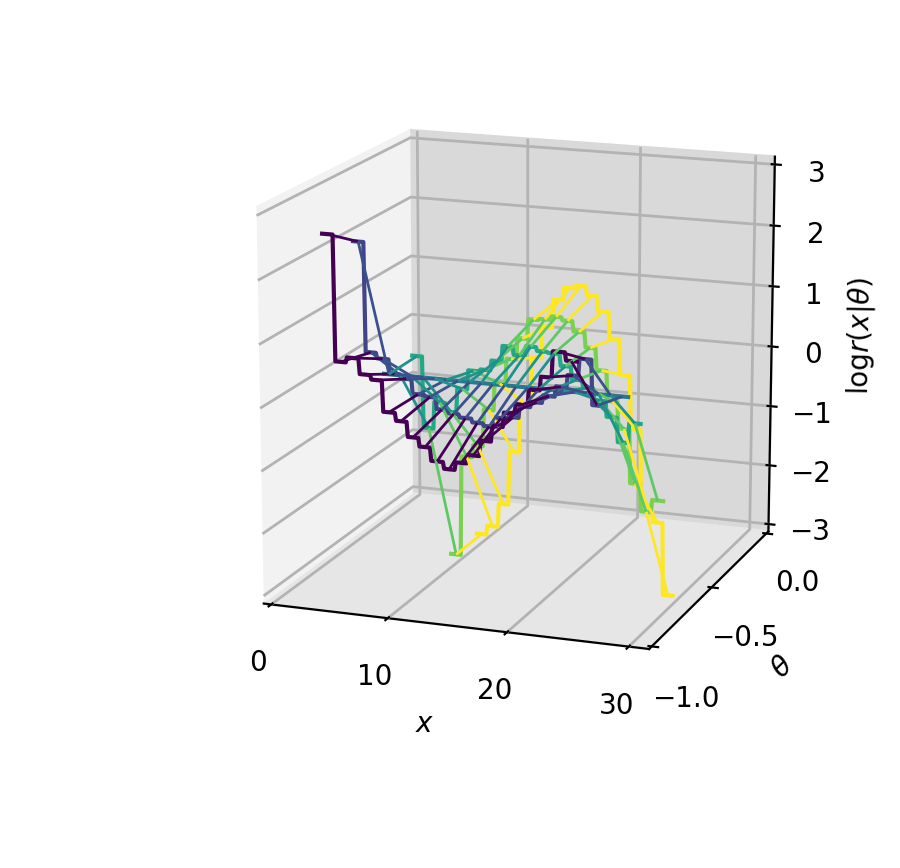

In [89]:
fig = custom_figure(1, 4.5, 1.)
ax = plt.subplot(1, 1, 1, projection="3d")

ax.view_init(elev=15., azim=-70)

# Lines with constant theta
for t, theta in reversed(list(enumerate(thetas))):
    x_ = np.linspace(xmin, xmax, n_positions * 10)
    p_ = np.asarray([logr_x[t][int(round(xi, 0))] for xi in x_])
    theta_ = theta * np.ones_like(x_)

    ax.plot(x_, theta_, p_, c=viridis_color(theta, -1., 0.), lw=1.5, alpha=1.)

# Lines of constant x
for x_ in range(n_positions):
    segments = []
    for t in range(n_thetas - 1):
        theta_begin = thetas[t]
        theta_end = thetas[t + 1]
        p_begin = logr_x[t][x_]
        p_end = logr_x[t + 1][x_]
        segments.append([(x_, theta_begin, p_begin), (x_, theta_end, p_end)])
    segments = np.asarray(segments)

    lc = Line3DCollection(segments, cmap="viridis")
    lc.set_array(thetas[:-1])
    lc.set_linewidth(1.)
    lc.set_alpha(1.)

    ax.add_collection(lc)

ax.set_xlabel("$x$")
ax.set_zlabel(r"$\log r(x| \theta)$")
ax.set_ylabel(r"$\theta$")
ax.set_xlim(0., 31.)
ax.set_zlim(-3.,3.)
ax.set_ylim(-1., 0.)
ax.set_xticks(np.linspace(0., 30., 4))
ax.set_yticks([-1., -0.5, 0.])
#ax.set_zticks([., 0.05, 0.1, 0.15, 0.2])

ax.dist = 10.

ax.w_xaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
ax.w_yaxis.set_pane_color((0.85, 0.85, 0.85, 1.0))
ax.w_zaxis.set_pane_color((0.9, 0.9, 0.9, 1.0))
ax.w_xaxis._axinfo.update(
    {"grid": {"color": (0.7, 0.7, 0.7, 1.), "linewidth": 1., "linestyle": "-"}}
)
ax.w_yaxis._axinfo.update(
    {"grid": {"color": (0.7, 0.7, 0.7, 0.), "linewidth": 1., "linestyle": "-"}}
)
ax.w_zaxis._axinfo.update(
    {"grid": {"color": (0.7, 0.7, 0.7, 1.), "linewidth": 1., "linestyle": "-"}}
)

#plt.savefig("figures/plinko_3d.pdf")
#plt.savefig("figures/plinko_3d.png")